# US Airport Network Visualization

## Framework
1. Download and clean data 
2. Munipulate data
    - get airport data
    - get routes data
    - get flight count data
    - get combined data of airport and flight count 
3. Make airport graph using networkx
4. Overlay airport network on map

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import numpy as np
import matplotlib.lines as mlines

## 1. Download and clean data
- download airport and routes data (https://openflights.org/data.html)
- clean routes data. Need to convert object data to numeric data type and drop nan values.

In [2]:
def download_data():
    # get airport data
    airport_cols = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
                   'Timezone', 'DST', 'Tz database time zone', 'Type', 'Source']
    airport_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat',
                             names=airport_cols)
    # get routes data
    route_cols = ['Airline', 'Airline ID', 'Source airport', 'Source airport ID',
                  'Dest airport', 'Dest airport ID', 'Codeshare', 'Stops', 'Equipment']
    route_df = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat',
                             names=route_cols)
    
    # clean route data
    # convert datatype, set nan if errors (non-number) raise 
    route_df['Source airport ID'] = pd.to_numeric(route_df['Source airport ID'].astype('str'), errors = 'coerce')
    route_df['Dest airport ID'] = pd.to_numeric(route_df['Dest airport ID'].astype('str'), errors = 'coerce')
    # drop nan values in the source airport ID and dest airport ID
    route_df.dropna(subset=['Source airport ID', 'Dest airport ID'], inplace=True)
    
    return airport_df, route_df

## 2. Munipulate data
- set two scenario airport data
    - US mainland airport data 
    - US mainland with Alaska and Hawaii airport data
- get four data frames 
    - US airport data
    - US routes data
    - US flight count data
    - US combined data

In [3]:
def get_country_main_df(airport_df, route_df, mainland=True):
    # only get US mainland airport data
    if mainland == True:
        us_airport_df = airport_df[(airport_df.Country == 'United States') \
                               & (airport_df.Lat > 25) & (airport_df.Lat < 50) \
                               & (airport_df.Long > -130) & (airport_df.Long < -60)]
    # airport including Alaska and Hawaii
    else:
        us_airport_df = airport_df[airport_df.Country == 'United States']
    
    airport_sub_cols= ['ID', 'Name','City','IATA', 'ICAO', 'Lat', 'Long']
    us_airport_df = us_airport_df.loc[:,airport_sub_cols]
    us_airport_df.reset_index(inplace=True, drop=True)
    
    # get US airport routes data
    # since now we only care about airport routes, we just get a subset of routes data
    route_sub_cols= ['Source airport','Source airport ID','Dest airport', 'Dest airport ID']
    us_route_df = route_df.loc[:,route_sub_cols]
    # get both the source airports and dest airports in all US airport
    us_route_df = us_route_df[(us_route_df['Source airport'].isin(us_airport_df['IATA'])) & 
                (us_route_df['Dest airport'].isin(us_airport_df['IATA']))]
    # get the number of routes between each source airport and dest airport
    us_route_df = us_route_df.groupby(['Source airport', 'Dest airport']).size().reset_index(name = 'Num_route')
    
    # get US total number of flights in each airport data
    # num of routes departing from each airport
    num_route_at_source_airport = us_route_df['Source airport'].value_counts().to_dict()
    # num of routes landing at each airport
    num_route_at_dest_airport = us_route_df['Dest airport'].value_counts().to_dict()
    # get total number of route in either source airport or in dest airport
    total_num_routes = {k: num_route_at_source_airport.get(k,0) + num_route_at_dest_airport.get(k,0) \
    for k in set(num_route_at_source_airport.keys()) | set(num_route_at_dest_airport.keys())} 
    # make a dataframe to hold the data of total flights
    us_flight_count = pd.DataFrame(data = total_num_routes.values(), index = total_num_routes.keys(), columns = ['Total_flight'])
    us_flight_count['IATA'] = us_flight_count.index.values
    
    # get US combined data by merging airport data with total flights data
    us_combined_data = us_airport_df.merge(us_flight_count, on = 'IATA')
    
    return us_airport_df, us_route_df, us_flight_count, us_combined_data


## 3. Make airport network graph

In [4]:
# make a airport network graph using networkx
def make_DiGraph(us_route_df):
    # make a graph and save the fig
    G = nx.from_pandas_edgelist(us_route_df, source = 'Source airport', 
                                target = 'Dest airport', 
                                edge_attr = 'Num_route',
                               create_using = nx.DiGraph())
    return G


## 4. Plot airport network graph on Basemap

In [5]:
# def plot_US_network_map_1(G, us_combined_data, us_flight_count, us_route_df, mainland=True):
def plot_US_network_map(G, mainland=True):
    if mainland == True: 
        # set up base map
        plt.figure(figsize = (16,9))
        m = Basemap(projection = 'merc',
                   llcrnrlon=-130,
                   llcrnrlat=25,
                   urcrnrlon=-60,
                   urcrnrlat=50,
                   lat_ts=0,
                   resolution='l',
                   suppress_ticks=True)
        node_size = 12
        font_size = 14
    else:
        plt.figure(figsize = (16,9))
        m = Basemap(projection = 'merc',
                   llcrnrlon=-180,
                   llcrnrlat=10,
                   urcrnrlon=-50,
                   urcrnrlat=70,
                   lat_ts=0,
                   resolution='l',
                   suppress_ticks=True)
        node_size = 4
        font_size = 10

    # project lat long onto basemap
    m_long, m_lat = m(us_combined_data['Long'].values, us_combined_data['Lat'].values)

    # make a dict to hold  map position
    pos = {}
    for IATA, long, lat in zip(us_combined_data['IATA'].values, m_long, m_lat):
        pos[IATA] = (long, lat)
        
    # draw seperate items (node, label, edge) on basemap
    large_nodes = [n for n in G.nodes() if us_flight_count['Total_flight'][n] >=100]
    large_node_size = [us_flight_count['Total_flight'][n]*node_size  for n in large_nodes]
    small_nodes = [n for n in G.nodes() if us_flight_count['Total_flight'][n] <100]
    small_node_size = [us_flight_count['Total_flight'][n]*node_size  for n in small_nodes]
    nx.draw_networkx_nodes(G, 
                           pos = pos, 
                           nodelist = large_nodes,
                           node_color = 'orange', 
                           alpha = 0.8,
                           node_size = large_node_size)

    nx.draw_networkx_labels(G, 
                            pos = pos, 
                            font_size=font_size,
                            labels = dict(zip(large_nodes,large_nodes)))
    nx.draw_networkx_nodes(G, 
                           pos = pos, 
                           nodelist = small_nodes,
                           node_color = 'yellow', 
                           alpha = 0.6,
                           node_size = small_node_size)

    nx.draw_networkx_edges(G,
                          pos = pos, 
                          edge_color = 'green', 
                          width = us_route_df['Num_route']*0.75, 
                          alpha=0.06, 
                          arrows = False)

    m.drawcountries(linewidth =3)
    m.drawstates(linewidth = 0.3)
    m.drawcoastlines(linewidth=2)
    m.fillcontinents(alpha = 0.2)
    line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="orange")
    line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="yellow")
    line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
    plt.legend((line1, line2, line3), ('Large Airport > 100 routes', 'Smaller Airports', 'Routes'),
           loc=3, fontsize = 'x-large')
    plt.tight_layout()
    if mainland: 
        plt.savefig("./map_mainland.png", format = "png", dpi = 300)
    else:
        plt.savefig("./map_wholeland.png", format = "png", dpi = 300)
    
    return plt

## Visualize US airport network graph
- mainland network map
- mainland and Alaska and Hawaii network map

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

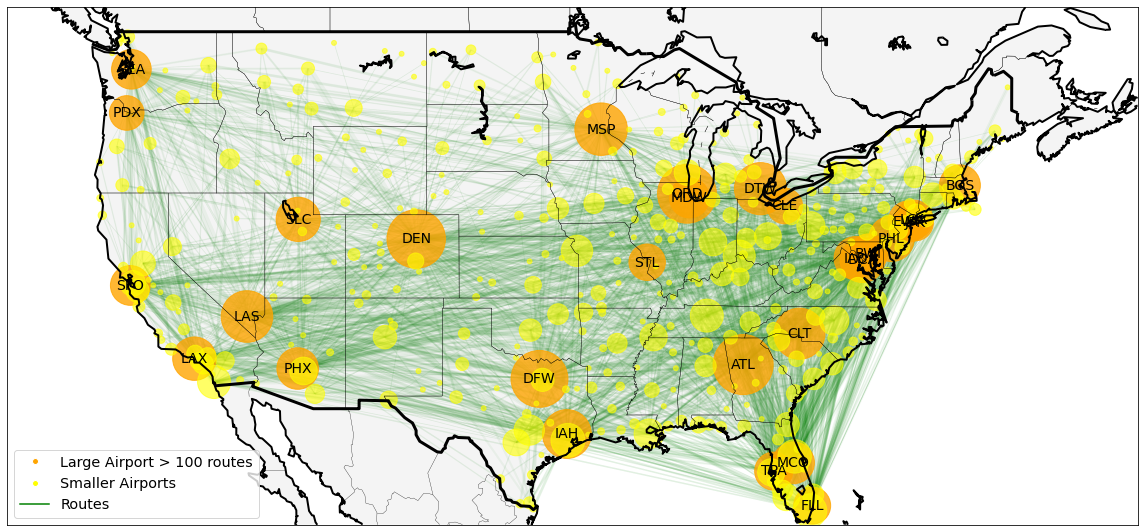

In [6]:
airport_df, route_df = download_data()

# get a network map of US mainland
us_airport_df, us_route_df, us_flight_count, us_combined_data = get_country_main_df(airport_df, route_df, mainland=True)
G = make_DiGraph(us_route_df)

plot_US_network_map(G, mainland=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

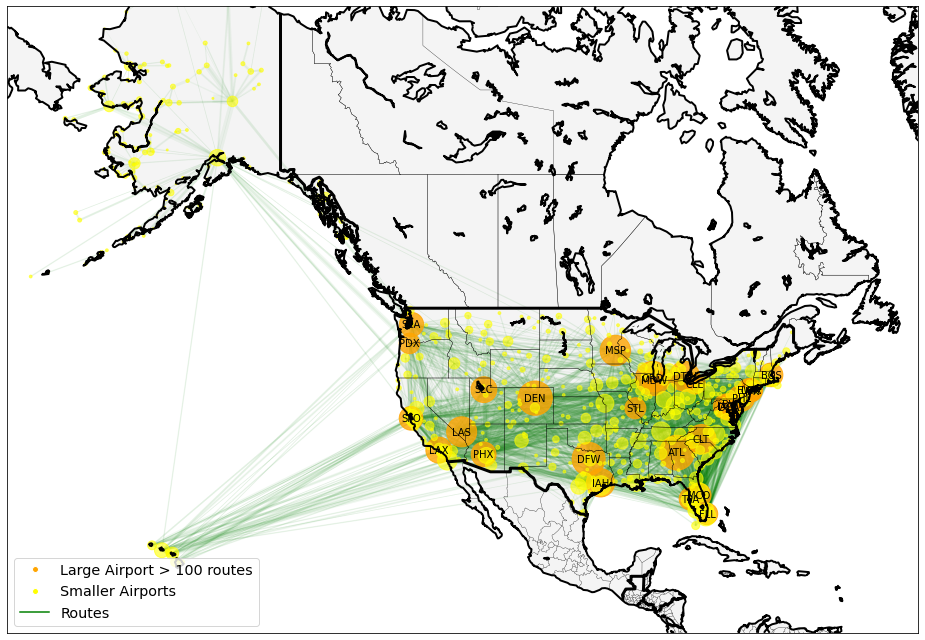

In [7]:
# get a network map of US including Alaska and Hawaii
us_airport_df, us_route_df, us_flight_count, us_combined_data = get_country_main_df(airport_df, route_df, mainland=False)
G = make_DiGraph(us_route_df)
plot_US_network_map(G, mainland=False)